In [ ]:
!pip install geopandas pandas numpy pykrige scikit-learn scikit-gstat gstools thefuzz dionysus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.5/708.5 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.6 MB/s eta 0:00:00
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440669 sha256=ae734f8f9bbc1cac6713c93e2a4dc2e7ec33d73062d9b39e59b02ef7aa57d309
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus


In [ ]:
!pip install cupy-cuda12x


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from shapely.geometry import Point

In [ ]:
import pandas as pd
df_weather = pd.read_csv('/content/drive/MyDrive/yield_classification/all_reshaped/all_data2001_2023_weather/complete_KNN_dataset_corrected.csv')



In [ ]:
df_weather.isna().sum()

,0
Date,0
county,0
mergedmax_temp,0
mergedmean_temp,0
mergedmin_temp,0
merged_precip,0
gdd,0


In [ ]:
df_weather = df_weather.rename(columns={'mergedmax_temp': 'max', 'mergedmean_temp':'meantemp', 'mergedmin_temp': 'min', 'merged_precip': 'rainfall' })
df_weather

,Date,county,max,meantemp,min,rainfall,gdd
0,2001-01-01,ADAMS,29.0,19.5,10.0,0.000000,0.0
1,2001-01-02,ADAMS,24.0,17.0,10.0,0.010000,0.0
2,2001-01-03,ADAMS,24.0,15.5,7.0,0.000000,0.0
3,2001-01-04,ADAMS,29.0,24.5,20.0,0.005000,0.0
4,2001-01-05,ADAMS,35.0,30.5,26.0,0.000000,0.0
...,...,...,...,...,...,...,...
535166,2023-12-27,WHITLEY,46.0,39.0,32.0,0.162000,0.0
535167,2023-12-28,WHITLEY,40.0,36.5,33.0,0.111429,0.0
535168,2023-12-29,WHITLEY,37.0,34.0,31.0,0.137143,0.0
535169,2023-12-30,WHITLEY,36.0,34.0,32.0,0.061429,0.0


In [ ]:
pip install --upgrade matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
!/usr/local/cuda/bin/nvcc --version


/bin/bash: line 1: /usr/local/cuda/bin/nvcc: No such file or directory


In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda/lib64:/usr/local/cuda-11/lib64'


## Topology Calculation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm  # For progress bar

# Load the weather data
df_weather = pd.read_csv('/content/drive/MyDrive/yield_classification/all_reshaped/all_data2001_2023_weather/complete_KNN_dataset_corrected.csv')

# Convert 'Date' column to datetime and extract year
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['year'] = df_weather['Date'].dt.year

# Remove rows with NaN or infinite values in critical columns
df_weather = df_weather.replace([np.inf, -np.inf], np.nan).dropna(subset=['mergedmin_temp', 'mergedmax_temp', 'mergedmean_temp', 'merged_precip'])

# Step 1: Function to compute zigzag persistence for weather data per year and county
def compute_zigzag_persistence(year_data, window_size=365, max_dimension=1, max_distance=2.0):
    """
    Computes topological features including distance quantiles, cosine similarities, and persistence features.

    :param year_data: Numpy array containing weather data for a year (e.g., 365 days)
    :param window_size: Size of the sliding window (e.g., 30 days)
    :param max_dimension: Maximum dimension for Vietoris-Rips complex (e.g., 1 for persistence of edges)
    :param max_distance: Maximum distance for the complex construction
    :return: A list of dictionaries with topological features for each sliding window
    """
    topological_features = []

    try:
        # Scale the weather data to the range [0, 1]
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(year_data.astype(np.float64))  # Convert to float64 to ensure compatibility

        for i in range(len(scaled_data) - window_size + 1):
            window = scaled_data[i:i + window_size]  # Extract a window of data (sliding window)

            # Step 1: Create a point cloud from the window
            point_cloud = window

            # Step 2: Compute Euclidean distances for the point cloud
            euclidean_dist = np.linalg.norm(point_cloud[:, None] - point_cloud, axis=-1)

            # Step 3: Compute Cosine Similarity with handling zero norms
            norms = np.linalg.norm(point_cloud, axis=1)
            norms[norms == 0] = 1e-10  # Replace zero norms with a small value to avoid division by zero
            cosine_dist = np.dot(point_cloud, point_cloud.T) / (norms[:, None] * norms[None, :])

            # Replace NaN values caused by numerical issues
            cosine_dist = np.nan_to_num(cosine_dist)

            # Step 4: Create the Vietoris-Rips filtration using the point cloud directly
            rips = d.fill_rips(point_cloud, max_dimension, max_distance)

            # Define the zigzag times (simple times assumed here)
            times = [[0, 1] for _ in range(len(rips))]
            zz, dgms, _ = d.zigzag_homology_persistence(rips, times)

            # Extract topological features
            birth_mean_0 = np.mean([p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            death_mean_0 = np.mean([p.death for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            life_mean_0 = np.mean([p.death - p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            num_bars_0 = len(dgms[0])

            birth_mean_1 = np.mean([p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            death_mean_1 = np.mean([p.death for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            life_mean_1 = np.mean([p.death - p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            num_bars_1 = len(dgms[1])

            # Calculate distance quantiles (Euclidean distances between points)
            dist_q0 = np.percentile(euclidean_dist, 0)
            dist_q1 = np.percentile(euclidean_dist, 25)
            dist_q2 = np.percentile(euclidean_dist, 50)
            dist_q3 = np.percentile(euclidean_dist, 75)
            dist_q4 = np.percentile(euclidean_dist, 100)

            # Calculate cosine similarity quantiles
            cos_sim_q0 = np.percentile(cosine_dist, 0)
            cos_sim_q1 = np.percentile(cosine_dist, 25)
            cos_sim_q2 = np.percentile(cosine_dist, 50)
            cos_sim_q3 = np.percentile(cosine_dist, 75)
            cos_sim_q4 = np.percentile(cosine_dist, 100)

            # Combine features into a dictionary for this window
            features = {
                'BirthMean_0': birth_mean_0,
                'DeathMean_0': death_mean_0,
                'LifeMean_0': life_mean_0,
                'NumBar_0': num_bars_0,
                'BirthMean_1': birth_mean_1,
                'DeathMean_1': death_mean_1,
                'LifeMean_1': life_mean_1,
                'NumBar_1': num_bars_1,
                'DistQ0': dist_q0,
                'DistQ1': dist_q1,
                'DistQ2': dist_q2,
                'DistQ3': dist_q3,
                'DistQ4': dist_q4,
                'CosSimQ0': cos_sim_q0,
                'CosSimQ1': cos_sim_q1,
                'CosSimQ2': cos_sim_q2,
                'CosSimQ3': cos_sim_q3,
                'CosSimQ4': cos_sim_q4
            }

            # Append the features for this window
            topological_features.append(features)

    except Exception as e:
        print(f"Error computing persistence for the year data: {e}")

    return topological_features

# Step 2: Define the process_county_year function to handle computation for each county-year group
def process_county_year(county, year, group):
    """
    Processes the zigzag persistence computation for a given county-year group.
    :param county: County name
    :param year: Year of the data
    :param group: DataFrame group for a specific county and year
    :return: List of dictionaries with topological features for each sliding window
    """
    try:
        # Extract the weather-related data as a NumPy array
        weather_data = group[['mergedmin_temp', 'mergedmax_temp', 'mergedmean_temp', 'merged_precip']].values

        # Convert the weather data to float64 to ensure compatibility
        weather_data = weather_data.astype(np.float64)

        # Compute zigzag persistence features for the given year and county
        topo_features = compute_zigzag_persistence(weather_data, window_size=365)

        # Add metadata to the topological features
        for feature in topo_features:
            feature['county'] = county
            feature['year'] = year

        return topo_features

    except Exception as e:
        print(f"Error processing county {county}, year {year}: {e}")
        return []

# Step 3: Use Joblib to parallelize the computation over counties and years
topological_features_all = Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(process_county_year)(county, year, group)
    for (county, year), group in tqdm(df_weather.groupby(['county', 'year']))
)

# Flatten the list of lists to create a master list
topological_features_all_flat = [item for sublist in topological_features_all for item in sublist]

# Step 4: Convert the list of dictionaries to a DataFrame for easy viewing and analysis
df_topological_features = pd.DataFrame(topological_features_all_flat)

# Step 5: Print the first few rows to see the result
print(df_topological_features.head())



  3%|▎         | 40/1458 [38:59<25:40:39, 65.19s/it]

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming df_weather contains daily weather data with columns ['date', 'county', 'min', 'max', 'meantemp', 'rainfall', 'gdd']
# df_yield contains yearly yield data with columns ['year', 'county', 'yield']
# df_soil contains static soil properties per county with 'county' as key

df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['Year'] = df_weather['Date'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

# Group weather data by county and year
grouped_weather = df_weather.groupby(['county', 'Year'])

# Prepare data
county_weather_sequences = {}
for (county, year), group in grouped_weather:
    if len(group) >= 365:  # Ensure there are at least 365 days in the data
        # Merge static soil data
        soil_data = df_yield[df_yield['County'] == county].iloc[0].drop('County').values
        daily_weather = group[['min', 'max', 'meantemp', 'rainfall', 'gdd']].values
        # Append soil data to each weather point
        daily_weather_with_soil = np.hstack([daily_weather, np.tile(soil_data, (daily_weather.shape[0], 1))])
        county_weather_sequences[(county, year)] = daily_weather_with_soil


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
import numpy as np

def compute_zigzag_persistence(year_data, window_size=365, max_dimension=1, max_distance=2.0):
    # Scale the weather data to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(year_data)

    topological_features = []

    for i in range(len(scaled_data) - window_size + 1):
        window = scaled_data[i:i + window_size]  # Extract a window of data (sliding window)

        # Create a point cloud from the window
        point_cloud = window

        try:
            # Create the Vietoris-Rips filtration
            rips = d.fill_rips(point_cloud, max_dimension, max_distance)

            # Define the zigzag times (here it's assumed each simplex has a time based on position in sequence)
            times = [[0, 1] for _ in range(len(rips))]  # Simple time range; adjust for your use case

            # Compute zigzag persistence
            zz, dgms, _ = d.zigzag_homology_persistence(rips, times)

            # Extract topological features (like mean birth, mean death, etc.)
            for dgm in dgms:
                births = [p.birth for p in dgm]
                deaths = [p.death for p in dgm if p.death != float('inf')]
                lifetimes = [p.death - p.birth for p in dgm if p.death != float('inf')]

                features = {
                    'birth_mean': np.mean(births),
                    'death_mean': np.mean(deaths),
                    'life_mean': np.mean(lifetimes) if lifetimes else 0,
                    'num_bars': len(dgm)
                }
                topological_features.append(features)

        except Exception as e:
            print(f"Error computing persistence: {e}")
            continue

    return topological_features


In [ ]:
county_topological_features = {}

# Loop through each county's weather data and compute topological features
for (county, year), weather_data in county_weather_sequences.items():
    topo_features = compute_zigzag_persistence(weather_data)
    county_topological_features[(county, year)] = topo_features

# Convert topological features into a DataFrame
topo_features_list = []
for (county, year), features in county_topological_features.items():
    for feature_set in features:
        topo_features_list.append({
            'county': county,
            'year': year,
            **feature_set
        })

df_topo_features = pd.DataFrame(topo_features_list)


NameError: name 'county_weather_sequences' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

def compute_zigzag_persistence(year_data, window_size=30, max_dimension=1, max_distance=2.0):
    """
    Computes topological features including distance quantiles, cosine similarities, and persistence features.

    :param year_data: Numpy array containing weather data for a year (e.g., 365 days)
    :param window_size: Size of the sliding window (e.g., 30 days)
    :param max_dimension: Maximum dimension for Vietoris-Rips complex (e.g., 1 for persistence of edges)
    :param max_distance: Maximum distance for the complex construction
    :return: A list of dictionaries with topological features for each sliding window
    """
    # Scale the weather data to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(year_data)

    topological_features = []

    for i in range(len(scaled_data) - window_size + 1):
        window = scaled_data[i:i + window_size]  # Extract a window of data (sliding window)

        # Step 1: Create a point cloud from the window
        point_cloud = window

        # Step 2: Compute Euclidean and Cosine distances for the point cloud
        euclidean_dist = euclidean_distances(point_cloud)
        cosine_dist = cosine_similarity(point_cloud)

        try:
            # Step 3: Create the Vietoris-Rips filtration using the point cloud directly
            rips = d.fill_rips(point_cloud, max_dimension, max_distance)

            # Define the zigzag times (simple times assumed here)
            times = [[0, 1] for _ in range(len(rips))]
            zz, dgms, _ = d.zigzag_homology_persistence(rips, times)

            # Step 4: Extract topological features from persistence diagrams
            birth_mean_0 = np.mean([p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            death_mean_0 = np.mean([p.death for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            life_mean_0 = np.mean([p.death - p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            num_bars_0 = len(dgms[0])

            birth_mean_1 = np.mean([p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            death_mean_1 = np.mean([p.death for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            life_mean_1 = np.mean([p.death - p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            num_bars_1 = len(dgms[1])

            # Step 5: Calculate distance quantiles (Euclidean distances between points)
            dist_q0 = np.percentile(euclidean_dist, 0)
            dist_q1 = np.percentile(euclidean_dist, 25)
            dist_q2 = np.percentile(euclidean_dist, 50)
            dist_q3 = np.percentile(euclidean_dist, 75)
            dist_q4 = np.percentile(euclidean_dist, 100)

            # Step 6: Calculate cosine similarity quantiles
            cos_sim_q0 = np.percentile(cosine_dist, 0)
            cos_sim_q1 = np.percentile(cosine_dist, 25)
            cos_sim_q2 = np.percentile(cosine_dist, 50)
            cos_sim_q3 = np.percentile(cosine_dist, 75)
            cos_sim_q4 = np.percentile(cosine_dist, 100)

            # Combine features into a dictionary for this window
            features = {
                'BirthMean_0': birth_mean_0,
                'DeathMean_0': death_mean_0,
                'LifeMean_0': life_mean_0,
                'NumBar_0': num_bars_0,
                'BirthMean_1': birth_mean_1,
                'DeathMean_1': death_mean_1,
                'LifeMean_1': life_mean_1,
                'NumBar_1': num_bars_1,
                'DistQ0': dist_q0,
                'DistQ1': dist_q1,
                'DistQ2': dist_q2,
                'DistQ3': dist_q3,
                'DistQ4': dist_q4,
                'CosSimQ0': cos_sim_q0,
                'CosSimQ1': cos_sim_q1,
                'CosSimQ2': cos_sim_q2,
                'CosSimQ3': cos_sim_q3,
                'CosSimQ4': cos_sim_q4
            }

            # Append the features for this window
            topological_features.append(features)

        except Exception as e:
            print(f"Error computing persistence: {e}")
            continue

    return topological_features

# Example: Assuming weather_data is a numpy array of shape (365, 5) for a single county
# Replace np.random.rand(365, 5) with your actual data



In [ ]:
import time
st = time.time()
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
# Parallelized computation using ProcessPoolExecutor
def process_county_weather(county_year_tuple):
    county, year = county_year_tuple
    weather_data = county_weather_sequences[(county, year)]
    return (county, year, compute_zigzag_persistence(weather_data))

# Run parallel processing
county_weather_sequences_keys = list(county_weather_sequences.keys())

with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_county_weather, county_weather_sequences_keys))

# Collect results into DataFrame
county_topological_features = {}
for county, year, topo_features in results:
    county_topological_features[(county, year)] = topo_features

# Convert to DataFrame
topo_features_list = []
for (county, year), features in county_topological_features.items():
    for feature_set in features:
        topo_features_list.append({
            'county': county,
            'year': year,
            **feature_set
        })

df_topo_features = pd.DataFrame(topo_features_list)
print(df_topo_features.head())


end = time.time()
print("Time taken:", end - st)

  county  year  BirthMean_0  DeathMean_0  LifeMean_0  NumBar_0  BirthMean_1  \
0  ALLEN  2016          0.0          1.0         1.0         1          0.0   
1  ALLEN  2016          0.0          1.0         1.0         1          0.0   
2  ALLEN  2016          0.0          1.0         1.0         1          0.0   
3  ALLEN  2016          0.0          1.0         1.0         1          0.0   
4  ALLEN  2016          0.0          1.0         1.0         1          0.0   

   DeathMean_1  LifeMean_1  NumBar_1  DistQ0    DistQ1    DistQ2    DistQ3  \
0          1.0         1.0       406     0.0  0.171509  0.310275  0.462601   
1          1.0         1.0       406     0.0  0.161533  0.309820  0.462601   
2          1.0         1.0       406     0.0  0.160392  0.305895  0.467521   
3          1.0         1.0       406     0.0  0.161533  0.309968  0.489290   
4          1.0         1.0       406     0.0  0.171509  0.316028  0.493071   

     DistQ4  CosSimQ0  CosSimQ1  CosSimQ2  CosSimQ3  Cos

In [ ]:
len(df_topo_features)

124709

In [ ]:
df_topo_features.to_csv('/content/drive/MyDrive/yield_classification/all_reshaped/topological_features.csv', index=False)

In [ ]:
df_topo_features

,county,year,BirthMean_0,DeathMean_0,LifeMean_0,NumBar_0,BirthMean_1,DeathMean_1,LifeMean_1,NumBar_1,DistQ0,DistQ1,DistQ2,DistQ3,DistQ4,CosSimQ0,CosSimQ1,CosSimQ2,CosSimQ3,CosSimQ4
0,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.171509,0.310275,0.462601,0.872377,0.882453,0.962050,0.981022,0.994501,1.0
1,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.161533,0.309820,0.462601,0.872377,0.882453,0.961917,0.981315,0.994910,1.0
2,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.160392,0.305895,0.467521,0.872377,0.882453,0.961917,0.981404,0.995183,1.0
3,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.161533,0.309968,0.489290,0.872377,0.882453,0.960807,0.981165,0.995183,1.0
4,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.171509,0.316028,0.493071,0.872377,0.882453,0.960520,0.981078,0.994505,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124704,WHITLEY,2022,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.116683,0.211402,0.345325,0.786858,0.948786,0.986985,0.994641,0.997980,1.0
124705,WHITLEY,2022,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.121716,0.232505,0.387945,0.786858,0.938216,0.984869,0.993907,0.997788,1.0
124706,WHITLEY,2022,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.125016,0.233970,0.387945,0.786858,0.938216,0.984466,0.993340,0.997493,1.0
124707,WHITLEY,2022,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.124172,0.233121,0.387945,0.786858,0.938216,0.984466,0.993461,0.997493,1.0


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
import numpy as np

# Assuming df_weather contains daily weather data with columns ['date', 'county', 'min', 'max', 'meantemp', 'rainfall', 'gdd']
# df_yield contains yearly yield data with columns ['year', 'county', 'yield']
# df_soil contains static soil properties per county with 'county' as key

df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['Year'] = df_weather['date'].dt.year  # Use the calendar year (Jan-Dec)

# Group weather data by county and year (calendar year)
grouped_weather = df_weather.groupby(['county', 'Year'])

# Prepare data
county_weather_sequences = {}
for (county, year), group in grouped_weather:
    if len(group) == 365:  # Ensure there are exactly 365 days in the data
        # Merge static soil data if needed
        soil_data = yield_soil[yield_soil['county'] == county].iloc[0].drop('county').values
        daily_weather = group[['min', 'max', 'meantemp', 'rainfall', 'GDD']].values
        # Append soil data to each weather point
        daily_weather_with_soil = np.hstack([daily_weather, np.tile(soil_data, (daily_weather.shape[0], 1))])
        county_weather_sequences[(county, year)] = daily_weather_with_soil

# Now, you can compute the topological features for each county-year combination using the full-year window


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

def compute_zigzag_persistence(year_data, window_size=365, max_dimension=1, max_distance=2.0):
    """
    Computes topological features including distance quantiles, cosine similarities, and persistence features.

    :param year_data: Numpy array containing weather data for a year (e.g., 365 days)
    :param window_size: Size of the sliding window (e.g., 30 days)
    :param max_dimension: Maximum dimension for Vietoris-Rips complex (e.g., 1 for persistence of edges)
    :param max_distance: Maximum distance for the complex construction
    :return: A list of dictionaries with topological features for each sliding window
    """
    # Scale the weather data to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(year_data)

    topological_features = []

    for i in range(len(scaled_data) - window_size + 1):
        window = scaled_data[i:i + window_size]  # Extract a window of data (sliding window)

        # Step 1: Create a point cloud from the window
        point_cloud = window

        # Step 2: Compute Euclidean and Cosine distances for the point cloud
        euclidean_dist = euclidean_distances(point_cloud)
        cosine_dist = cosine_similarity(point_cloud)

        try:
            # Step 3: Create the Vietoris-Rips filtration using the point cloud directly
            rips = d.fill_rips(point_cloud, max_dimension, max_distance)

            # Define the zigzag times (simple times assumed here)
            times = [[0, 1] for _ in range(len(rips))]
            zz, dgms, _ = d.zigzag_homology_persistence(rips, times)

            # Step 4: Extract topological features from persistence diagrams
            birth_mean_0 = np.mean([p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            death_mean_0 = np.mean([p.death for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            life_mean_0 = np.mean([p.death - p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            num_bars_0 = len(dgms[0])

            birth_mean_1 = np.mean([p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            death_mean_1 = np.mean([p.death for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            life_mean_1 = np.mean([p.death - p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            num_bars_1 = len(dgms[1])

            # Step 5: Calculate distance quantiles (Euclidean distances between points)
            dist_q0 = np.percentile(euclidean_dist, 0)
            dist_q1 = np.percentile(euclidean_dist, 25)
            dist_q2 = np.percentile(euclidean_dist, 50)
            dist_q3 = np.percentile(euclidean_dist, 75)
            dist_q4 = np.percentile(euclidean_dist, 100)

            # Step 6: Calculate cosine similarity quantiles
            cos_sim_q0 = np.percentile(cosine_dist, 0)
            cos_sim_q1 = np.percentile(cosine_dist, 25)
            cos_sim_q2 = np.percentile(cosine_dist, 50)
            cos_sim_q3 = np.percentile(cosine_dist, 75)
            cos_sim_q4 = np.percentile(cosine_dist, 100)

            # Combine features into a dictionary for this window
            features = {
                'BirthMean_0': birth_mean_0,
                'DeathMean_0': death_mean_0,
                'LifeMean_0': life_mean_0,
                'NumBar_0': num_bars_0,
                'BirthMean_1': birth_mean_1,
                'DeathMean_1': death_mean_1,
                'LifeMean_1': life_mean_1,
                'NumBar_1': num_bars_1,
                'DistQ0': dist_q0,
                'DistQ1': dist_q1,
                'DistQ2': dist_q2,
                'DistQ3': dist_q3,
                'DistQ4': dist_q4,
                'CosSimQ0': cos_sim_q0,
                'CosSimQ1': cos_sim_q1,
                'CosSimQ2': cos_sim_q2,
                'CosSimQ3': cos_sim_q3,
                'CosSimQ4': cos_sim_q4
            }

            # Append the features for this window
            topological_features.append(features)

        except Exception as e:
            print(f"Error computing persistence: {e}")
            continue

    return topological_features

# Example: Assuming weather_data is a numpy array of shape (365, 5) for a single county
# Replace np.random.rand(365, 5) with your actual data



In [ ]:
import time
st = time.time()
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
# Parallelized computation using ProcessPoolExecutor
def process_county_weather(county_year_tuple):
    county, year = county_year_tuple
    weather_data = county_weather_sequences[(county, year)]
    return (county, year, compute_zigzag_persistence(weather_data))

# Run parallel processing
county_weather_sequences_keys = list(county_weather_sequences.keys())

with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_county_weather, county_weather_sequences_keys))

# Collect results into DataFrame
county_topological_features = {}
for county, year, topo_features in results:
    county_topological_features[(county, year)] = topo_features

# Convert to DataFrame
topo_features_list = []
for (county, year), features in county_topological_features.items():
    for feature_set in features:
        topo_features_list.append({
            'county': county,
            'year': year,
            **feature_set
        })

df_topo_features = pd.DataFrame(topo_features_list)
print(df_topo_features.head())


end = time.time()
print("Time taken:", end - st)

NameError: name 'compute_zigzag_persistence' is not defined

In [ ]:
 #Check how many days of weather data you have for 2016
for (county, year), group in grouped_weather:
    if year == 2016:
        print(f"County: {county}, Year: {year}, Days of data: {len(group)}")

County: ALLEN, Year: 2016, Days of data: 366
County: BARTHOLOMEW, Year: 2016, Days of data: 366
County: BLACKFORD, Year: 2016, Days of data: 366
County: BOONE, Year: 2016, Days of data: 366
County: CASS, Year: 2016, Days of data: 366
County: CLINTON, Year: 2016, Days of data: 366
County: DAVIESS, Year: 2016, Days of data: 366
County: DECATUR, Year: 2016, Days of data: 366
County: DELAWARE, Year: 2016, Days of data: 366
County: DUBOIS, Year: 2016, Days of data: 366
County: ELKHART, Year: 2016, Days of data: 366
County: FRANKLIN, Year: 2016, Days of data: 366
County: FULTON, Year: 2016, Days of data: 366
County: GIBSON, Year: 2016, Days of data: 366
County: GRANT, Year: 2016, Days of data: 366
County: HAMILTON, Year: 2016, Days of data: 366
County: HANCOCK, Year: 2016, Days of data: 366
County: HENRY, Year: 2016, Days of data: 366
County: HOWARD, Year: 2016, Days of data: 366
County: HUNTINGTON, Year: 2016, Days of data: 366
County: JASPER, Year: 2016, Days of data: 366
County: JAY, Year

In [ ]:
import pandas as pd
import numpy as np

# Assuming df_weather contains daily weather data with columns ['date', 'county', 'min', 'max', 'meantemp', 'rainfall', 'gdd']
# Assuming df_yield contains yearly yield data with columns ['year', 'county', 'yield']

# Convert 'date' to datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

# Extract the year directly from the 'date' column
df_weather['Year'] = df_weather['Date'].dt.year

# Group weather data by county and year (January to December)
grouped_weather = df_weather.groupby(['county', 'Year'])

# Prepare the data for each county and year
county_weather_sequences = {}

for (county, year), group in grouped_weather:
    # Sort by date to ensure proper chronological order
    group = group.sort_values('Date')

    # Ensure at least 365 days of data (for leap years, take the first 365 days)
    if len(group) >= 365:
        # Take the first 365 days of data for each county and year
        daily_weather = group[['min', 'max', 'meantemp', 'rainfall']].values[:365]
        # Store the weather data for each (county, year) combination
        county_weather_sequences[(county, year)] = daily_weather

# After processing, county_weather_sequences will contain weather data for each (county, year) pair.


In [ ]:
county_weather_sequences

{('ADAMS',
  2001): array([[1.00e+01, 2.90e+01, 1.95e+01, 0.00e+00],
        [1.00e+01, 2.40e+01, 1.70e+01, 1.00e-02],
        [7.00e+00, 2.40e+01, 1.55e+01, 0.00e+00],
        ...,
        [1.30e+01, 2.10e+01, 1.70e+01, 0.00e+00],
        [1.40e+01, 2.10e+01, 1.75e+01, 0.00e+00],
        [1.40e+01, 2.20e+01, 1.80e+01, 0.00e+00]]),
 ('ADAMS',
  2002): array([[9.00e+00, 2.70e+01, 1.80e+01, 0.00e+00],
        [1.20e+01, 3.30e+01, 2.25e+01, 0.00e+00],
        [1.50e+01, 3.30e+01, 2.40e+01, 0.00e+00],
        ...,
        [2.80e+01, 3.50e+01, 3.15e+01, 0.00e+00],
        [3.10e+01, 5.30e+01, 4.20e+01, 5.00e-02],
        [3.20e+01, 4.90e+01, 4.05e+01, 2.95e-01]]),
 ('ADAMS',
  2005): array([[37.   , 59.   , 48.   ,  0.   ],
        [36.   , 51.   , 43.5  ,  0.21 ],
        [37.   , 57.   , 47.   ,  0.63 ],
        ...,
        [34.5  , 53.   , 43.75 ,  0.875],
        [34.   , 37.   , 35.5  ,  0.   ],
        [34.   , 39.   , 36.5  ,  0.29 ]]),
 ('ADAMS',
  2006): array([[3.100e+01, 3.750e+

In [ ]:
import cupy as cp
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time

# Function for computing zigzag persistence (already GPU-accelerated)
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

import cupy as cp
import numpy as np

def compute_zigzag_persistence_gpu(year_data, window_size=30, max_dimension=1, max_distance=2.0):
    """
    Computes topological features including distance quantiles, cosine similarities, and persistence features on GPU.

    :param year_data: Numpy array containing weather data for a year (e.g., 365 days)
    :param window_size: Size of the sliding window (e.g., 30 days)
    :param max_dimension: Maximum dimension for Vietoris-Rips complex (e.g., 1 for persistence of edges)
    :param max_distance: Maximum distance for the complex construction
    :return: A list of dictionaries with topological features for each sliding window
    """
    # Ensure year_data is numeric and in a proper format
    year_data = np.asarray(year_data, dtype=np.float32)  # Convert to float32

    # Move data to the GPU using CuPy
    year_data_gpu = cp.asarray(year_data)

    # Scale the weather data to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(cp.asnumpy(year_data_gpu))  # Convert to NumPy for MinMaxScaler

    # Move back to GPU after scaling
    scaled_data_gpu = cp.asarray(scaled_data)

    topological_features = []

    for i in range(len(scaled_data_gpu) - window_size + 1):
        window_gpu = scaled_data_gpu[i:i + window_size]  # Extract a window of data (sliding window)

        # Step 1: Create a point cloud from the window
        point_cloud_gpu = window_gpu

        # Step 2: Compute Euclidean and Cosine distances using CuPy on GPU
        euclidean_dist_gpu = cp.linalg.norm(point_cloud_gpu[:, None] - point_cloud_gpu, axis=2)
        cosine_dist_gpu = cp.dot(point_cloud_gpu, point_cloud_gpu.T) / (
            cp.linalg.norm(point_cloud_gpu, axis=1)[:, None] * cp.linalg.norm(point_cloud_gpu, axis=1)[None, :]
        )

        # Move distance matrices back to CPU (NumPy) for use in Dionysus
        euclidean_dist = cp.asnumpy(euclidean_dist_gpu)
        cosine_dist = cp.asnumpy(cosine_dist_gpu)

        try:
            # Step 3: Create the Vietoris-Rips filtration using the point cloud directly
            rips = d.fill_rips(euclidean_dist, max_dimension, max_distance)

            # Define the zigzag times (simple times assumed here)
            times = [[0, 1] for _ in range(len(rips))]
            zz, dgms, _ = d.zigzag_homology_persistence(rips, times)

            # Step 4: Extract topological features from persistence diagrams
            birth_mean_0 = np.mean([p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            death_mean_0 = np.mean([p.death for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            life_mean_0 = np.mean([p.death - p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            num_bars_0 = len(dgms[0])

            birth_mean_1 = np.mean([p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            death_mean_1 = np.mean([p.death for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            life_mean_1 = np.mean([p.death - p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            num_bars_1 = len(dgms[1])

            # Step 5: Calculate distance quantiles (Euclidean distances between points)
            dist_q0 = np.percentile(euclidean_dist, 0)
            dist_q1 = np.percentile(euclidean_dist, 25)
            dist_q2 = np.percentile(euclidean_dist, 50)
            dist_q3 = np.percentile(euclidean_dist, 75)
            dist_q4 = np.percentile(euclidean_dist, 100)

            # Step 6: Calculate cosine similarity quantiles
            cos_sim_q0 = np.percentile(cosine_dist, 0)
            cos_sim_q1 = np.percentile(cosine_dist, 25)
            cos_sim_q2 = np.percentile(cosine_dist, 50)
            cos_sim_q3 = np.percentile(cosine_dist, 75)
            cos_sim_q4 = np.percentile(cosine_dist, 100)

            # Combine features into a dictionary for this window
            features = {
                'BirthMean_0': birth_mean_0,
                'DeathMean_0': death_mean_0,
                'LifeMean_0': life_mean_0,
                'NumBar_0': num_bars_0,
                'BirthMean_1': birth_mean_1,
                'DeathMean_1': death_mean_1,
                'LifeMean_1': life_mean_1,
                'NumBar_1': num_bars_1,
                'DistQ0': dist_q0,
                'DistQ1': dist_q1,
                'DistQ2': dist_q2,
                'DistQ3': dist_q3,
                'DistQ4': dist_q4,
                'CosSimQ0': cos_sim_q0,
                'CosSimQ1': cos_sim_q1,
                'CosSimQ2': cos_sim_q2,
                'CosSimQ3': cos_sim_q3,
                'CosSimQ4': cos_sim_q4
            }

            # Append the features for this window
            topological_features.append(features)

        except Exception as e:
            print(f"Error computing persistence: {e}")
            continue

    return topological_features


# Prepare weather data sequences (for illustration)
# Assume `county_weather_sequences` is prepared from earlier steps

# Helper function for parallel execution
def process_county_weather(county_year_tuple):
    county, year = county_year_tuple
    weather_data = county_weather_sequences[(county, year)]
    return (county, year, compute_zigzag_persistence_gpu(weather_data))

# Execution with Parallelization
st = time.time()

# Parallelized computation using ProcessPoolExecutor
county_weather_sequences_keys = list(county_weather_sequences.keys())

with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_county_weather, county_weather_sequences_keys))

# Collect results into a DataFrame
county_topological_features = {}
for county, year, topo_features in results:
    county_topological_features[(county, year)] = topo_features

# Convert to DataFrame
topo_features_list = []
for (county, year), features in county_topological_features.items():
    for feature_set in features:
        topo_features_list.append({
            'county': county,
            'year': year,
            **feature_set
        })

df_topo_features = pd.DataFrame(topo_features_list)
print(df_topo_features.head())

end = time.time()
print(f"Time taken: {end - st} seconds")


KeyboardInterrupt: 

In [ ]:
df_topo_features.to_csv('/content/drive/MyDrive/yield_classification/all_reshaped/topological_features_30d_gpus.csv', index=False)

In [ ]:
df_topo_features

,county,year,BirthMean_0,DeathMean_0,LifeMean_0,NumBar_0,BirthMean_1,DeathMean_1,LifeMean_1,NumBar_1,DistQ0,DistQ1,DistQ2,DistQ3,DistQ4,CosSimQ0,CosSimQ1,CosSimQ2,CosSimQ3,CosSimQ4
0,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,404,0.0,0.116249,0.222872,0.341819,0.730997,0.723081,0.969517,0.989012,0.996782,1.0
1,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,392,0.0,0.127224,0.232755,0.367787,0.785522,0.723081,0.970797,0.989815,0.997162,1.0
2,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,383,0.0,0.131424,0.243546,0.377829,0.785522,0.723081,0.972054,0.990118,0.997344,1.0
3,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,374,0.0,0.132954,0.248217,0.390742,0.785522,0.723081,0.972054,0.990157,0.997409,1.0
4,ALLEN,2016,0.0,1.0,1.0,1,0.0,1.0,1.0,355,0.0,0.142977,0.260340,0.409116,0.827914,0.723081,0.970444,0.989450,0.997220,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142459,WHITLEY,2023,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.140042,0.223464,0.310406,0.724851,0.891252,0.971451,0.988259,0.995234,1.0
142460,WHITLEY,2023,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.133147,0.211191,0.290691,0.530874,0.891252,0.972889,0.988782,0.995482,1.0
142461,WHITLEY,2023,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.131485,0.210423,0.289387,0.530874,0.891252,0.972436,0.988889,0.995528,1.0
142462,WHITLEY,2023,0.0,1.0,1.0,1,0.0,1.0,1.0,406,0.0,0.130150,0.210423,0.289387,0.530874,0.891252,0.972079,0.988873,0.995548,1.0


In [ ]:
import cupy as cp
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time

# Function for computing zigzag persistence (already GPU-accelerated)
from sklearn.preprocessing import MinMaxScaler
import dionysus as d
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

import cupy as cp
import numpy as np

def compute_zigzag_persistence_gpu(year_data, window_size=365, max_dimension=1, max_distance=2.0):
    """
    Computes topological features including distance quantiles, cosine similarities, and persistence features on GPU.

    :param year_data: Numpy array containing weather data for a year (e.g., 365 days)
    :param window_size: Size of the sliding window (e.g., 30 days)
    :param max_dimension: Maximum dimension for Vietoris-Rips complex (e.g., 1 for persistence of edges)
    :param max_distance: Maximum distance for the complex construction
    :return: A list of dictionaries with topological features for each sliding window
    """
    # Ensure year_data is numeric and in a proper format
    year_data = np.asarray(year_data, dtype=np.float32)  # Convert to float32

    # Move data to the GPU using CuPy
    year_data_gpu = cp.asarray(year_data)

    # Scale the weather data to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(cp.asnumpy(year_data_gpu))  # Convert to NumPy for MinMaxScaler

    # Move back to GPU after scaling
    scaled_data_gpu = cp.asarray(scaled_data)

    topological_features = []

    for i in range(len(scaled_data_gpu) - window_size + 1):
        window_gpu = scaled_data_gpu[i:i + window_size]  # Extract a window of data (sliding window)

        # Step 1: Create a point cloud from the window
        point_cloud_gpu = window_gpu

        # Step 2: Compute Euclidean and Cosine distances using CuPy on GPU
        euclidean_dist_gpu = cp.linalg.norm(point_cloud_gpu[:, None] - point_cloud_gpu, axis=2)
        cosine_dist_gpu = cp.dot(point_cloud_gpu, point_cloud_gpu.T) / (
            cp.linalg.norm(point_cloud_gpu, axis=1)[:, None] * cp.linalg.norm(point_cloud_gpu, axis=1)[None, :]
        )

        # Move distance matrices back to CPU (NumPy) for use in Dionysus
        euclidean_dist = cp.asnumpy(euclidean_dist_gpu)
        cosine_dist = cp.asnumpy(cosine_dist_gpu)

        try:
            # Step 3: Create the Vietoris-Rips filtration using the point cloud directly
            rips = d.fill_rips(euclidean_dist, max_dimension, max_distance)

            # Define the zigzag times (simple times assumed here)
            times = [[0, 1] for _ in range(len(rips))]
            zz, dgms, _ = d.zigzag_homology_persistence(rips, times)

            # Step 4: Extract topological features from persistence diagrams
            birth_mean_0 = np.mean([p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            death_mean_0 = np.mean([p.death for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            life_mean_0 = np.mean([p.death - p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            num_bars_0 = len(dgms[0])

            birth_mean_1 = np.mean([p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            death_mean_1 = np.mean([p.death for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            life_mean_1 = np.mean([p.death - p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            num_bars_1 = len(dgms[1])

            # Step 5: Calculate distance quantiles (Euclidean distances between points)
            dist_q0 = np.percentile(euclidean_dist, 0)
            dist_q1 = np.percentile(euclidean_dist, 25)
            dist_q2 = np.percentile(euclidean_dist, 50)
            dist_q3 = np.percentile(euclidean_dist, 75)
            dist_q4 = np.percentile(euclidean_dist, 100)

            # Step 6: Calculate cosine similarity quantiles
            cos_sim_q0 = np.percentile(cosine_dist, 0)
            cos_sim_q1 = np.percentile(cosine_dist, 25)
            cos_sim_q2 = np.percentile(cosine_dist, 50)
            cos_sim_q3 = np.percentile(cosine_dist, 75)
            cos_sim_q4 = np.percentile(cosine_dist, 100)

            # Combine features into a dictionary for this window
            features = {
                'BirthMean_0': birth_mean_0,
                'DeathMean_0': death_mean_0,
                'LifeMean_0': life_mean_0,
                'NumBar_0': num_bars_0,
                'BirthMean_1': birth_mean_1,
                'DeathMean_1': death_mean_1,
                'LifeMean_1': life_mean_1,
                'NumBar_1': num_bars_1,
                'DistQ0': dist_q0,
                'DistQ1': dist_q1,
                'DistQ2': dist_q2,
                'DistQ3': dist_q3,
                'DistQ4': dist_q4,
                'CosSimQ0': cos_sim_q0,
                'CosSimQ1': cos_sim_q1,
                'CosSimQ2': cos_sim_q2,
                'CosSimQ3': cos_sim_q3,
                'CosSimQ4': cos_sim_q4
            }

            # Append the features for this window
            topological_features.append(features)

        except Exception as e:
            print(f"Error computing persistence: {e}")
            continue

    return topological_features


# Prepare weather data sequences (for illustration)
# Assume `county_weather_sequences` is prepared from earlier steps

# Helper function for parallel execution
def process_county_weather(county_year_tuple):
    county, year = county_year_tuple
    weather_data = county_weather_sequences[(county, year)]
    return (county, year, compute_zigzag_persistence_gpu(weather_data))

# Execution with Parallelization
st = time.time()

# Parallelized computation using ProcessPoolExecutor
county_weather_sequences_keys = list(county_weather_sequences.keys())

with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_county_weather, county_weather_sequences_keys))

# Collect results into a DataFrame
county_topological_features = {}
for county, year, topo_features in results:
    county_topological_features[(county, year)] = topo_features

# Convert to DataFrame
topo_features_list = []
for (county, year), features in county_topological_features.items():
    for feature_set in features:
        topo_features_list.append({
            'county': county,
            'year': year,
            **feature_set
        })

df_topo_features = pd.DataFrame(topo_features_list)
print(df_topo_features.head())

end = time.time()
print(f"Time taken: {end - st} seconds")


  county  year  BirthMean_0  DeathMean_0  LifeMean_0  NumBar_0  BirthMean_1  \
0  ADAMS  2001          0.0          1.0         1.0         3          0.0   
1  ADAMS  2002          0.0          1.0         1.0        10          0.0   
2  ADAMS  2005          0.0          1.0         1.0         7          0.0   
3  ADAMS  2006          0.0          1.0         1.0         3          0.0   
4  ADAMS  2007          0.0          1.0         1.0         3          0.0   

   DeathMean_1  LifeMean_1  NumBar_1  DistQ0    DistQ1    DistQ2    DistQ3  \
0          1.0         1.0      7634     0.0  0.266328  0.500183  0.803705   
1          1.0         1.0      7842     0.0  0.265844  0.517614  0.816367   
2          1.0         1.0      8069     0.0  0.250802  0.490791  0.796564   
3          1.0         1.0      9320     0.0  0.232436  0.425260  0.678850   
4          1.0         1.0     10067     0.0  0.214379  0.450874  0.746337   

     DistQ4  CosSimQ0  CosSimQ1  CosSimQ2  CosSimQ3  Cos

In [ ]:
!nvidia-smi # Check driver version


Wed Oct 23 17:44:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0              34W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
df_topo_features.to_csv('/content/drive/MyDrive/yield_classification/all_reshaped/topological_features_365d_gpus.csv', index=False)
df_topo_features

,county,year,BirthMean_0,DeathMean_0,LifeMean_0,NumBar_0,BirthMean_1,DeathMean_1,LifeMean_1,NumBar_1,DistQ0,DistQ1,DistQ2,DistQ3,DistQ4,CosSimQ0,CosSimQ1,CosSimQ2,CosSimQ3,CosSimQ4
0,ADAMS,2001,0.0,1.0,1.0,3,0.0,1.0,1.0,7634,0.0,0.266328,0.500183,0.803705,1.855520,0.000000,0.965423,0.989318,0.996962,1.0
1,ADAMS,2002,0.0,1.0,1.0,10,0.0,1.0,1.0,7842,0.0,0.265844,0.517614,0.816367,1.830613,NaN,NaN,NaN,NaN,NaN
2,ADAMS,2005,0.0,1.0,1.0,7,0.0,1.0,1.0,8069,0.0,0.250802,0.490791,0.796564,1.717780,0.000000,0.975132,0.993333,0.998537,1.0
3,ADAMS,2006,0.0,1.0,1.0,3,0.0,1.0,1.0,9320,0.0,0.232436,0.425260,0.678850,1.724996,NaN,NaN,NaN,NaN,NaN
4,ADAMS,2007,0.0,1.0,1.0,3,0.0,1.0,1.0,10067,0.0,0.214379,0.450874,0.746337,1.741927,0.000000,0.986038,0.995427,0.999048,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,WHITLEY,2019,0.0,1.0,1.0,2,0.0,1.0,1.0,10189,0.0,0.211250,0.413207,0.674676,1.871202,0.000000,0.987087,0.996156,0.999301,1.0
1452,WHITLEY,2020,0.0,1.0,1.0,4,0.0,1.0,1.0,8454,0.0,0.251553,0.476454,0.798306,1.815275,0.051443,0.949560,0.985222,0.996562,1.0
1453,WHITLEY,2021,0.0,1.0,1.0,4,0.0,1.0,1.0,9214,0.0,0.240605,0.485006,0.781734,1.709748,0.122426,0.975432,0.992278,0.998120,1.0
1454,WHITLEY,2022,0.0,1.0,1.0,5,0.0,1.0,1.0,10170,0.0,0.217249,0.405210,0.659035,1.768163,0.010035,0.986249,0.995485,0.998822,1.0


In [ ]:
topo_feature = pd.read_csv('/content/drive/MyDrive/yield_classification/all_reshaped/topological_features_365d_gpus.csv')
topo_feature

,county,year,BirthMean_0,DeathMean_0,LifeMean_0,NumBar_0,BirthMean_1,DeathMean_1,LifeMean_1,NumBar_1,DistQ0,DistQ1,DistQ2,DistQ3,DistQ4,CosSimQ0,CosSimQ1,CosSimQ2,CosSimQ3,CosSimQ4
0,ALLEN,2016,0.0,1.0,1.0,5,0.0,1.0,1.0,8775,0.0,0.241746,0.455547,0.743114,1.775866,0.000000,0.978050,0.993551,0.998730,1.0
1,ALLEN,2017,0.0,1.0,1.0,3,0.0,1.0,1.0,9479,0.0,0.221368,0.423879,0.683310,1.724862,NaN,NaN,NaN,NaN,NaN
2,ALLEN,2018,0.0,1.0,1.0,7,0.0,1.0,1.0,10644,0.0,0.211831,0.454696,0.718725,1.765864,NaN,NaN,NaN,NaN,NaN
3,ALLEN,2019,0.0,1.0,1.0,3,0.0,1.0,1.0,9020,0.0,0.229149,0.452610,0.701480,1.779685,0.000000,0.981148,0.995996,0.999108,1.0
4,ALLEN,2020,0.0,1.0,1.0,7,0.0,1.0,1.0,8829,0.0,0.238630,0.463299,0.754072,1.732469,0.004555,0.976354,0.992019,0.998007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,WHITLEY,2019,0.0,1.0,1.0,2,0.0,1.0,1.0,10115,0.0,0.212103,0.413377,0.676842,1.871202,0.000000,0.986704,0.996060,0.999273,1.0
420,WHITLEY,2020,0.0,1.0,1.0,3,0.0,1.0,1.0,8218,0.0,0.257164,0.483348,0.809370,1.815275,0.051443,0.943670,0.983363,0.996405,1.0
421,WHITLEY,2021,0.0,1.0,1.0,3,0.0,1.0,1.0,9082,0.0,0.243018,0.481267,0.771782,1.736502,0.125762,0.974370,0.992043,0.998069,1.0
422,WHITLEY,2022,0.0,1.0,1.0,5,0.0,1.0,1.0,10243,0.0,0.217342,0.404724,0.658145,1.768163,0.010035,0.986337,0.995464,0.998817,1.0


In [ ]:
import cupy as cp
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time

# Function for computing zigzag persistence (GPU-accelerated)
from sklearn.preprocessing import MinMaxScaler
import dionysus as d

# Ensure the proper handling of NaNs in cosine similarity
def safe_cosine_similarity(point_cloud_gpu):
    """
    Compute cosine similarity, handling cases where the norm is zero to avoid NaN values.
    """
    norms = cp.linalg.norm(point_cloud_gpu, axis=1)
    # Avoid division by zero by replacing zero norms with a small epsilon
    norms = cp.where(norms == 0, 1e-10, norms)
    cosine_dist_gpu = cp.dot(point_cloud_gpu, point_cloud_gpu.T) / (norms[:, None] * norms[None, :])
    return cosine_dist_gpu

def compute_zigzag_persistence_gpu(year_data, window_size=365, max_dimension=1, max_distance=2.0):
    """
    Computes topological features including distance quantiles, cosine similarities, and persistence features on GPU.

    :param year_data: Numpy array containing weather data for a year (e.g., 365 days)
    :param window_size: Size of the sliding window (e.g., 365 days)
    :param max_dimension: Maximum dimension for Vietoris-Rips complex (e.g., 1 for persistence of edges)
    :param max_distance: Maximum distance for the complex construction
    :return: A list of dictionaries with topological features for each sliding window
    """
    # Ensure year_data is numeric and in a proper format
    year_data = np.asarray(year_data, dtype=np.float32)  # Convert to float32

    # Move data to the GPU using CuPy
    year_data_gpu = cp.asarray(year_data)

    # Scale the weather data to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(cp.asnumpy(year_data_gpu))  # Convert to NumPy for MinMaxScaler

    # Move back to GPU after scaling
    scaled_data_gpu = cp.asarray(scaled_data)

    topological_features = []

    for i in range(len(scaled_data_gpu) - window_size + 1):
        window_gpu = scaled_data_gpu[i:i + window_size]  # Extract a window of data (sliding window)

        # Step 1: Create a point cloud from the window
        point_cloud_gpu = window_gpu

        # Step 2: Compute Euclidean and Cosine distances using CuPy on GPU
        euclidean_dist_gpu = cp.linalg.norm(point_cloud_gpu[:, None] - point_cloud_gpu, axis=2)
        cosine_dist_gpu = safe_cosine_similarity(point_cloud_gpu)  # Use safe cosine similarity function

        # Move distance matrices back to CPU (NumPy) for use in Dionysus
        euclidean_dist = cp.asnumpy(euclidean_dist_gpu)
        cosine_dist = cp.asnumpy(cosine_dist_gpu)

        try:
            # Step 3: Create the Vietoris-Rips filtration using the point cloud directly
            rips = d.fill_rips(euclidean_dist, max_dimension, max_distance)

            # Define the zigzag times (simple times assumed here)
            times = [[0, 1] for _ in range(len(rips))]
            zz, dgms, _ = d.zigzag_homology_persistence(rips, times)

            # Step 4: Extract topological features from persistence diagrams
            birth_mean_0 = np.mean([p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            death_mean_0 = np.mean([p.death for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            life_mean_0 = np.mean([p.death - p.birth for p in dgms[0]]) if len(dgms[0]) > 0 else 0
            num_bars_0 = len(dgms[0])

            birth_mean_1 = np.mean([p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            death_mean_1 = np.mean([p.death for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            life_mean_1 = np.mean([p.death - p.birth for p in dgms[1]]) if len(dgms[1]) > 0 else 0
            num_bars_1 = len(dgms[1])

            # Step 5: Calculate distance quantiles (Euclidean distances between points)
            dist_q0 = np.percentile(euclidean_dist, 0)
            dist_q1 = np.percentile(euclidean_dist, 25)
            dist_q2 = np.percentile(euclidean_dist, 50)
            dist_q3 = np.percentile(euclidean_dist, 75)
            dist_q4 = np.percentile(euclidean_dist, 100)

            # Step 6: Calculate cosine similarity quantiles
            cos_sim_q0 = np.percentile(cosine_dist, 0)
            cos_sim_q1 = np.percentile(cosine_dist, 25)
            cos_sim_q2 = np.percentile(cosine_dist, 50)
            cos_sim_q3 = np.percentile(cosine_dist, 75)
            cos_sim_q4 = np.percentile(cosine_dist, 100)

            # Combine features into a dictionary for this window
            features = {
                'BirthMean_0': birth_mean_0,
                'DeathMean_0': death_mean_0,
                'LifeMean_0': life_mean_0,
                'NumBar_0': num_bars_0,
                'BirthMean_1': birth_mean_1,
                'DeathMean_1': death_mean_1,
                'LifeMean_1': life_mean_1,
                'NumBar_1': num_bars_1,
                'DistQ0': dist_q0,
                'DistQ1': dist_q1,
                'DistQ2': dist_q2,
                'DistQ3': dist_q3,
                'DistQ4': dist_q4,
                'CosSimQ0': cos_sim_q0,
                'CosSimQ1': cos_sim_q1,
                'CosSimQ2': cos_sim_q2,
                'CosSimQ3': cos_sim_q3,
                'CosSimQ4': cos_sim_q4
            }

            # Append the features for this window
            topological_features.append(features)

        except Exception as e:
            print(f"Error computing persistence: {e}")
            continue

    return topological_features


# Helper function for parallel execution
def process_county_weather(county_year_tuple):
    county, year = county_year_tuple
    weather_data = county_weather_sequences[(county, year)]
    return (county, year, compute_zigzag_persistence_gpu(weather_data))

# Execution with Parallelization
st = time.time()

# Parallelized computation using ProcessPoolExecutor
county_weather_sequences_keys = list(county_weather_sequences.keys())

with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_county_weather, county_weather_sequences_keys))

# Collect results into a DataFrame
county_topological_features = {}
for county, year, topo_features in results:
    county_topological_features[(county, year)] = topo_features

# Convert to DataFrame
topo_features_list = []
for (county, year), features in county_topological_features.items():
    for feature_set in features:
        topo_features_list.append({
            'county': county,
            'year': year,
            **feature_set
        })

df_topo_features = pd.DataFrame(topo_features_list)
print(df_topo_features.head())

end = time.time()
print(f"Time taken: {end - st} seconds")


  county  year  BirthMean_0  DeathMean_0  LifeMean_0  NumBar_0  BirthMean_1  \
0  ADAMS  2001          0.0          1.0         1.0         3          0.0   
1  ADAMS  2002          0.0          1.0         1.0        10          0.0   
2  ADAMS  2005          0.0          1.0         1.0         7          0.0   
3  ADAMS  2006          0.0          1.0         1.0         3          0.0   
4  ADAMS  2007          0.0          1.0         1.0         3          0.0   

   DeathMean_1  LifeMean_1  NumBar_1  DistQ0    DistQ1    DistQ2    DistQ3  \
0          1.0         1.0      7634     0.0  0.266328  0.500183  0.803705   
1          1.0         1.0      7842     0.0  0.265844  0.517614  0.816367   
2          1.0         1.0      8069     0.0  0.250802  0.490791  0.796564   
3          1.0         1.0      9320     0.0  0.232436  0.425260  0.678850   
4          1.0         1.0     10067     0.0  0.214379  0.450874  0.746337   

     DistQ4  CosSimQ0  CosSimQ1  CosSimQ2  CosSimQ3  Cos

In [ ]:
df_topo_features.to_csv('/content/drive/MyDrive/yield_classification/all_reshaped/topological_features_365d_gpus.csv', index=False)
df_topo_features

,county,year,BirthMean_0,DeathMean_0,LifeMean_0,NumBar_0,BirthMean_1,DeathMean_1,LifeMean_1,NumBar_1,DistQ0,DistQ1,DistQ2,DistQ3,DistQ4,CosSimQ0,CosSimQ1,CosSimQ2,CosSimQ3,CosSimQ4
0,ADAMS,2001,0.0,1.0,1.0,3,0.0,1.0,1.0,7634,0.0,0.266328,0.500183,0.803705,1.855520,0.000000,0.965423,0.989318,0.996962,1.0
1,ADAMS,2002,0.0,1.0,1.0,10,0.0,1.0,1.0,7842,0.0,0.265844,0.517614,0.816367,1.830613,0.000000,0.966523,0.991715,0.998095,1.0
2,ADAMS,2005,0.0,1.0,1.0,7,0.0,1.0,1.0,8069,0.0,0.250802,0.490791,0.796564,1.717780,0.000000,0.975132,0.993333,0.998537,1.0
3,ADAMS,2006,0.0,1.0,1.0,3,0.0,1.0,1.0,9320,0.0,0.232436,0.425260,0.678850,1.724996,0.000000,0.981186,0.993118,0.998070,1.0
4,ADAMS,2007,0.0,1.0,1.0,3,0.0,1.0,1.0,10067,0.0,0.214379,0.450874,0.746337,1.741927,0.000000,0.986038,0.995427,0.999048,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,WHITLEY,2019,0.0,1.0,1.0,2,0.0,1.0,1.0,10189,0.0,0.211250,0.413207,0.674676,1.871202,0.000000,0.987087,0.996156,0.999301,1.0
1452,WHITLEY,2020,0.0,1.0,1.0,4,0.0,1.0,1.0,8454,0.0,0.251553,0.476454,0.798306,1.815275,0.051443,0.949560,0.985222,0.996562,1.0
1453,WHITLEY,2021,0.0,1.0,1.0,4,0.0,1.0,1.0,9214,0.0,0.240605,0.485006,0.781734,1.709748,0.122426,0.975432,0.992278,0.998120,1.0
1454,WHITLEY,2022,0.0,1.0,1.0,5,0.0,1.0,1.0,10170,0.0,0.217249,0.405210,0.659035,1.768163,0.010035,0.986249,0.995485,0.998822,1.0


## Analyzing ZZ Topology

In [ ]:
df_topo_features = pd.read_csv('/content/drive/MyDrive/yield_classification/all_reshaped/topological_features_365d_gpus.csv')
df_topo_features

,county,year,BirthMean_0,DeathMean_0,LifeMean_0,NumBar_0,BirthMean_1,DeathMean_1,LifeMean_1,NumBar_1,DistQ0,DistQ1,DistQ2,DistQ3,DistQ4,CosSimQ0,CosSimQ1,CosSimQ2,CosSimQ3,CosSimQ4
0,ADAMS,2001,0.0,1.0,1.0,3,0.0,1.0,1.0,7634,0.0,0.266328,0.500183,0.803705,1.855520,0.000000,0.965423,0.989318,0.996962,1.0
1,ADAMS,2002,0.0,1.0,1.0,10,0.0,1.0,1.0,7842,0.0,0.265844,0.517614,0.816367,1.830613,0.000000,0.966523,0.991715,0.998095,1.0
2,ADAMS,2005,0.0,1.0,1.0,7,0.0,1.0,1.0,8069,0.0,0.250802,0.490791,0.796564,1.717780,0.000000,0.975132,0.993333,0.998537,1.0
3,ADAMS,2006,0.0,1.0,1.0,3,0.0,1.0,1.0,9320,0.0,0.232436,0.425260,0.678850,1.724996,0.000000,0.981186,0.993118,0.998070,1.0
4,ADAMS,2007,0.0,1.0,1.0,3,0.0,1.0,1.0,10067,0.0,0.214379,0.450874,0.746337,1.741927,0.000000,0.986038,0.995427,0.999048,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,WHITLEY,2019,0.0,1.0,1.0,2,0.0,1.0,1.0,10189,0.0,0.211250,0.413207,0.674676,1.871202,0.000000,0.987087,0.996156,0.999301,1.0
1452,WHITLEY,2020,0.0,1.0,1.0,4,0.0,1.0,1.0,8454,0.0,0.251553,0.476454,0.798306,1.815275,0.051443,0.949560,0.985222,0.996562,1.0
1453,WHITLEY,2021,0.0,1.0,1.0,4,0.0,1.0,1.0,9214,0.0,0.240605,0.485006,0.781734,1.709748,0.122426,0.975432,0.992278,0.998120,1.0
1454,WHITLEY,2022,0.0,1.0,1.0,5,0.0,1.0,1.0,10170,0.0,0.217249,0.405210,0.659035,1.768163,0.010035,0.986249,0.995485,0.998822,1.0


In [ ]:
df_yield = pd.read_csv('/content/drive/MyDrive/yield_classification/corn2001_2023_yield_data.csv')

yield_data = df_yield.rename(columns={'Year': 'year', 'Value':'yield','County':'county' })


In [ ]:
yield_data = yield_data[['year', 'county', 'yield']]

In [ ]:
yield_data

,year,county,yield
0,2023,OTHER COUNTIES,202.5
1,2023,BARTHOLOMEW,195.0
2,2023,BOONE,207.2
3,2023,CLINTON,234.4
4,2023,DECATUR,221.9
...,...,...,...
1980,2001,PUTNAM,157.8
1981,2001,TIPPECANOE,157.5
1982,2001,VERMILLION,160.6
1983,2001,VIGO,148.7


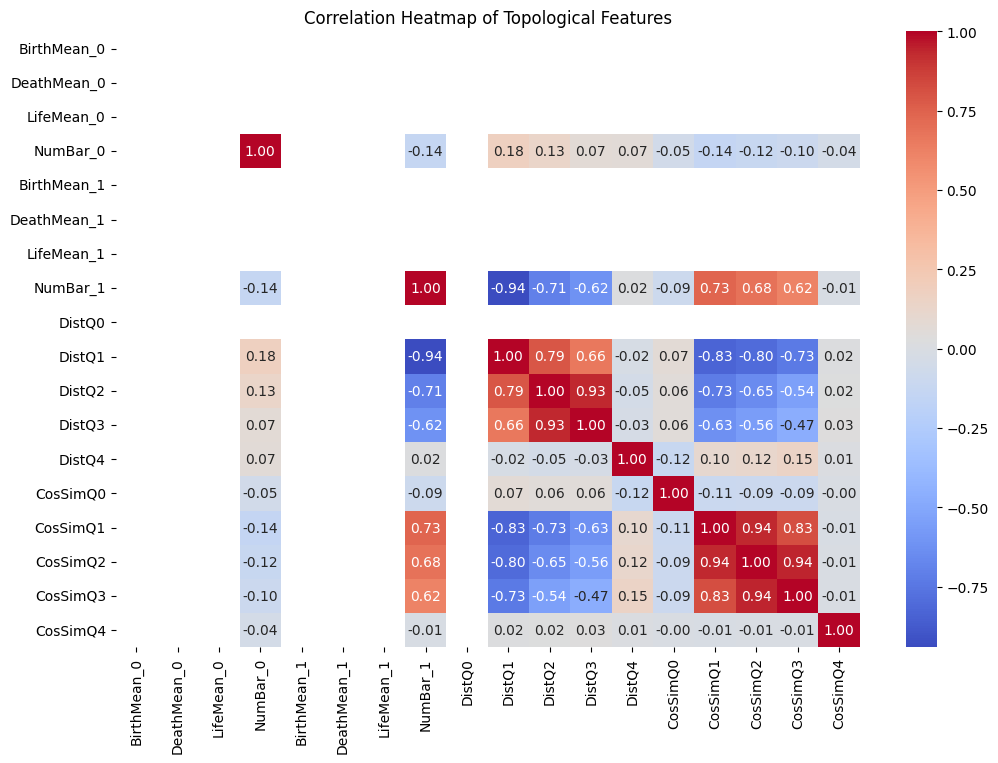

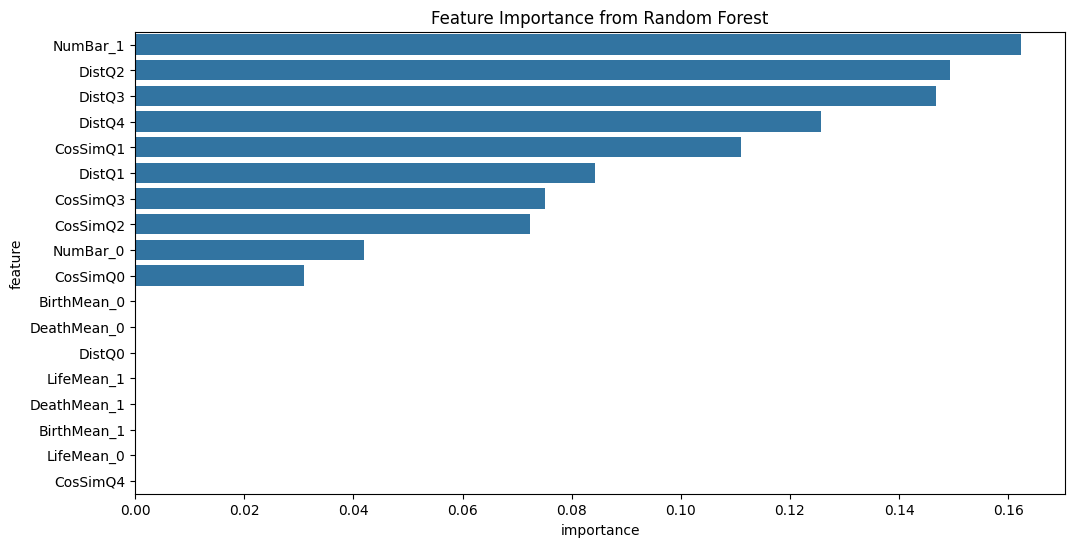

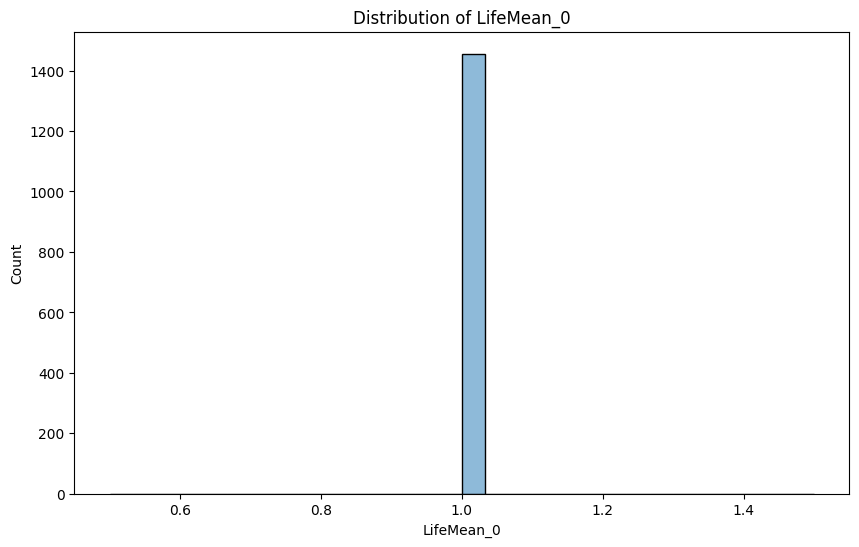

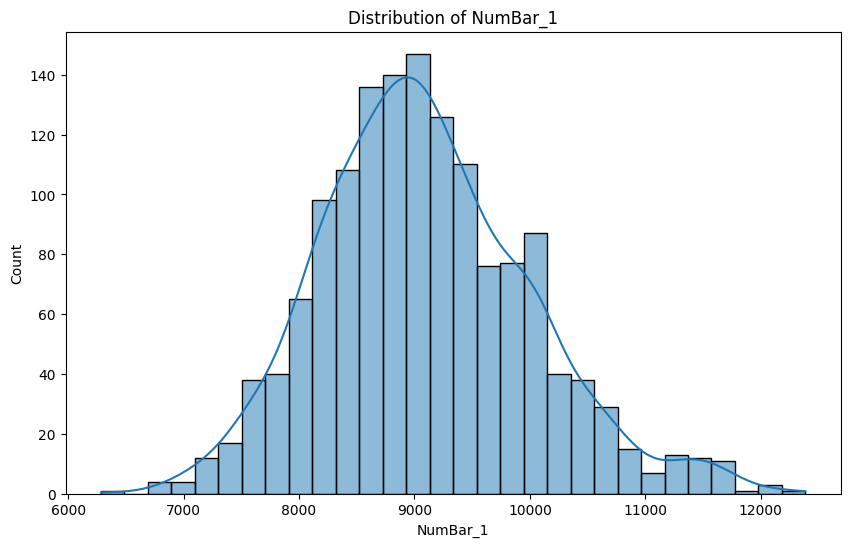

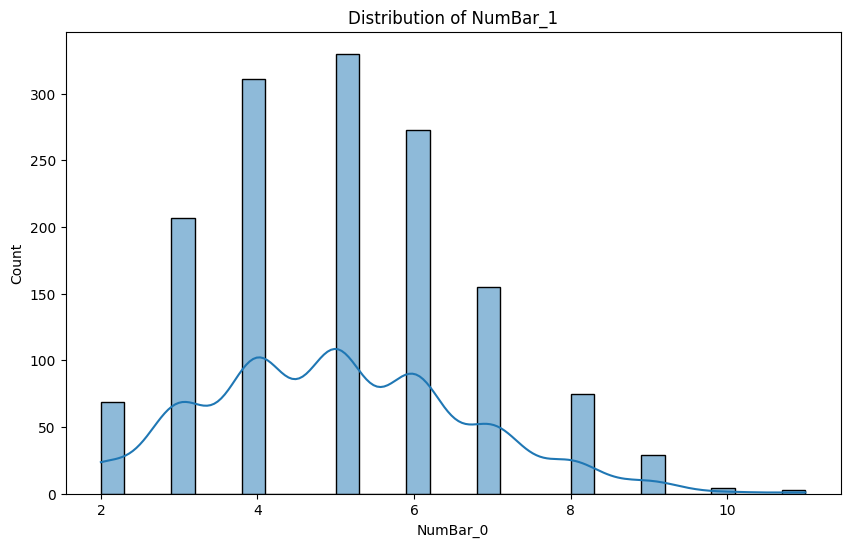

In [ ]:
# Let's implement statistical and visualization analysis on the topological features.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# Assuming df_topo_features is already available as result of topological feature extraction.
# Replace this with the real dataframe (df_topo_features) after topology computation.

# Step 1: Pairwise correlations and heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df_topo_features.drop(['county', 'year'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Topological Features')
plt.show()

'''
# Step 2: PCA analysis on topological features
pca = PCA(n_components=2)
features_for_pca = df_topo_features.drop(['county', 'year'], axis=1).fillna(0)  # Handle any missing values
pca_result = pca.fit_transform(features_for_pca)

df_topo_features['PCA1'] = pca_result[:, 0]
df_topo_features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='county', data=df_topo_features, palette='Set1')
plt.title('PCA of Topological Features by County')
plt.show()
'''

# Merge df_topo_feature and yield_data based on 'county' and 'year'
merged_df = df_topo_features.merge(yield_data, on=['county', 'year'], how='inner')

# Display the merged dataframe
merged_df
# Step 3: Random Forest to assess feature importance
# Example: If we assume there's a yield or target column available
# (This can be changed to match your use case)
if 'yield' in merged_df.columns:  # Add this part if yield is available
    X = merged_df.drop(['county', 'year', 'yield'], axis=1).fillna(0)
    y = merged_df['yield']

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X, y)

    # Plot feature importances
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Feature Importance from Random Forest')
    plt.show()

# Step 4: Distribution of specific features
plt.figure(figsize=(10, 6))
sns.histplot(df_topo_features['LifeMean_0'], kde=True, bins=30)
plt.title('Distribution of LifeMean_0')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_topo_features['NumBar_1'], kde=True, bins=30)
plt.title('Distribution of NumBar_1')
plt.show()



plt.figure(figsize=(10, 6))
sns.histplot(df_topo_features['NumBar_0'], kde=True, bins=30)
plt.title('Distribution of NumBar_1')
plt.show()

# # If the yield column is available:
# if 'yield' in df_topo_features.columns:
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x='LifeMean_1', y='yield', hue='county', data=df_topo_features, palette='Set1')
#     plt.title('LifeMean_1 vs Yield by County')
#     plt.show()




In [ ]:
county_boundary = gpd.read_file('/content/drive/MyDrive/yield_classification/Census_County_TIGER00_IN.shp')
county_boundary = county_boundary.to_crs(epsg=4326)
indiana_map = county_boundary[['NAME_U', 'geometry']]
indiana_map.rename(columns={'NAME_U': 'county'}, inplace=True)
indiana_map.set_geometry('geometry', inplace=True)
indiana_map

<ipython-input-27-794bd222e78b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiana_map.rename(columns={'NAME_U': 'county'}, inplace=True)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,county,geometry
0,STEUBEN,"POLYGON ((-84.84041 41.76011, -84.82062 41.760..."
1,LAGRANGE,"POLYGON ((-85.2156 41.75973, -85.19665 41.7597..."
2,ELKHART,"POLYGON ((-85.67938 41.75914, -85.65994 41.759..."
3,ST JOSEPH,"POLYGON ((-86.0814 41.76065, -86.06265 41.7605..."
4,LAKE,"POLYGON ((-87.50003 41.76018, -87.22329 41.760..."
...,...,...
87,PERRY,"POLYGON ((-86.58836 38.26558, -86.57006 38.266..."
88,WARRICK,"POLYGON ((-87.31689 38.24614, -87.29823 38.246..."
89,POSEY,"POLYGON ((-87.9835 38.23042, -87.97451 38.2303..."
90,SPENCER,"POLYGON ((-86.79156 38.20522, -86.79138 38.190..."


In [ ]:
# Ensure the county names in both datasets match properly (clean if necessary)
# Merge shapefile GeoDataFrame with the features dataset on the 'county' column
merged_df = df_topo_features.merge(indiana_map, on='county')

# Verify the merged data
print(merged_df.head())
print(merged_df.shape)

  county  year  BirthMean_0  DeathMean_0  LifeMean_0  NumBar_0  BirthMean_1  \
0  ADAMS  2001          0.0          1.0         1.0         3          0.0   
1  ADAMS  2002          0.0          1.0         1.0        10          0.0   
2  ADAMS  2005          0.0          1.0         1.0         7          0.0   
3  ADAMS  2006          0.0          1.0         1.0         3          0.0   
4  ADAMS  2007          0.0          1.0         1.0         3          0.0   

   DeathMean_1  LifeMean_1  NumBar_1  ...    DistQ1    DistQ2    DistQ3  \
0          1.0         1.0      7634  ...  0.266328  0.500183  0.803705   
1          1.0         1.0      7842  ...  0.265844  0.517614  0.816367   
2          1.0         1.0      8069  ...  0.250802  0.490791  0.796564   
3          1.0         1.0      9320  ...  0.232436  0.425260  0.678850   
4          1.0         1.0     10067  ...  0.214379  0.450874  0.746337   

     DistQ4  CosSimQ0  CosSimQ1  CosSimQ2  CosSimQ3  CosSimQ4  \
0  1.8555

In [ ]:
merged_df.columns

Index(['county', 'year', 'BirthMean_0', 'DeathMean_0', 'LifeMean_0',
       'NumBar_0', 'BirthMean_1', 'DeathMean_1', 'LifeMean_1', 'NumBar_1',
       'DistQ0', 'DistQ1', 'DistQ2', 'DistQ3', 'DistQ4', 'CosSimQ0',
       'CosSimQ1', 'CosSimQ2', 'CosSimQ3', 'CosSimQ4', 'geometry'],
      dtype='object')

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming 'Static_county_data' is already loaded and is a GeoDataFrame
features = ['NumBar_0', 'NumBar_1', 'DistQ1', 'DistQ2', 'DistQ3', 'DistQ4', 'CosSimQ0', 'CosSimQ1', 'CosSimQ2', 'CosSimQ3']

# Compute Z-scores for the relevant columns

# Calculate Z-scores for each feature
df_topo_features[features] = df_topo_features[features].apply(lambda x: zscore(x, ddof=1))

# Verify the Z-scores are calculated correctly
print(df_topo_features[features].head())
print(df_topo_features)

   NumBar_0  NumBar_1    DistQ1    DistQ2    DistQ3    DistQ4  CosSimQ0  \
0 -1.218755 -1.602939  1.646310  1.323797  1.179653  1.169657  -0.29597   
1  3.003390 -1.374446  1.618925  1.863385  1.415400  0.819932  -0.29597   
2  1.193899 -1.125082  0.767383  1.033049  1.046709 -0.764433  -0.29597   
3 -1.218755  0.249169 -0.272286 -0.995584 -1.144902 -0.663104  -0.29597   
4 -1.218755  1.069765 -1.294526 -0.202662  0.111580 -0.425362  -0.29597   

   CosSimQ1  CosSimQ2  CosSimQ3  
0 -1.399578 -1.686911 -2.593549  
1 -1.270192 -0.694220 -0.593863  
2 -0.257529 -0.024163  0.186078  
3  0.454547 -0.112969 -0.637118  
4  1.025277  0.843554  1.089678  
       county  year  BirthMean_0  DeathMean_0  LifeMean_0  NumBar_0  \
0       ADAMS  2001          0.0          1.0         1.0 -1.218755   
1       ADAMS  2002          0.0          1.0         1.0  3.003390   
2       ADAMS  2005          0.0          1.0         1.0  1.193899   
3       ADAMS  2006          0.0          1.0         1.0 -1.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def makemap(df, cmap, colmn):


  # Extract year from the 'Date' column and add it as a new column



  # Reorder columns to match the desired structure


  # Determine unique years
  unique_years = df['year'].unique()

# Determine number of rows and columns for subplots
  num_rows = 2
  num_cols = 4

  # Create subplots with a standard gap between plots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 14), sharex=True, sharey=True, constrained_layout=True, dpi = 100)
  fig.suptitle(colmn, fontsize = 30)
  # Loop through each unique year in the data
  for i, year in enumerate(unique_years):
      # Calculate the row and column index for the current subplot
      row = i // num_cols
      col = i % num_cols

      # Filter data for the current year
      data_year = df[df['year'] == year]

      # Merge data with county geometries
      merged_data = indiana_map.merge(data_year, left_on='county', right_on='county', how='left')

      # Get current axes
      ax = axes[row, col]

      # Plot the map
      merged_data.plot(ax=ax, column=colmn, cmap=cmap, edgecolor='black',
                      missing_kwds={
                          "color": "grey",
                          "edgecolor": "black",
                          "hatch": "///",
                          "label": "Missing Data"
                      })

      # Plot state boundary
      indiana_map.plot(ax=ax, color='none', edgecolor='black')

      # Set plot title and labels
      ax.set_title(f'{year}')

      # Set font size individually for each element
      ax.title.set_fontsize(20)
      ax.xaxis.label.set_fontsize(20)
      ax.yaxis.label.set_fontsize(20)
      ax.tick_params(axis='both', which='major', labelsize=19)

      # Add X-axis label only for the last row
      if row == num_rows - 1:
          ax.set_xlabel('Longitude', fontsize=20)

      # Add Y-axis label only for the first column
      if col == 0:
          ax.set_ylabel('Latitude', fontsize=20)

      cbar = fig.colorbar(ax.get_children()[0], ax=ax)
      # Set font size for colorbar
      cbar.ax.tick_params(labelsize=25)

  # Adjust layout

  #plt.tight_layout()
  # name = 'plots/' + outfile
  # plt.savefig(name)
  # Show plot

  plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2

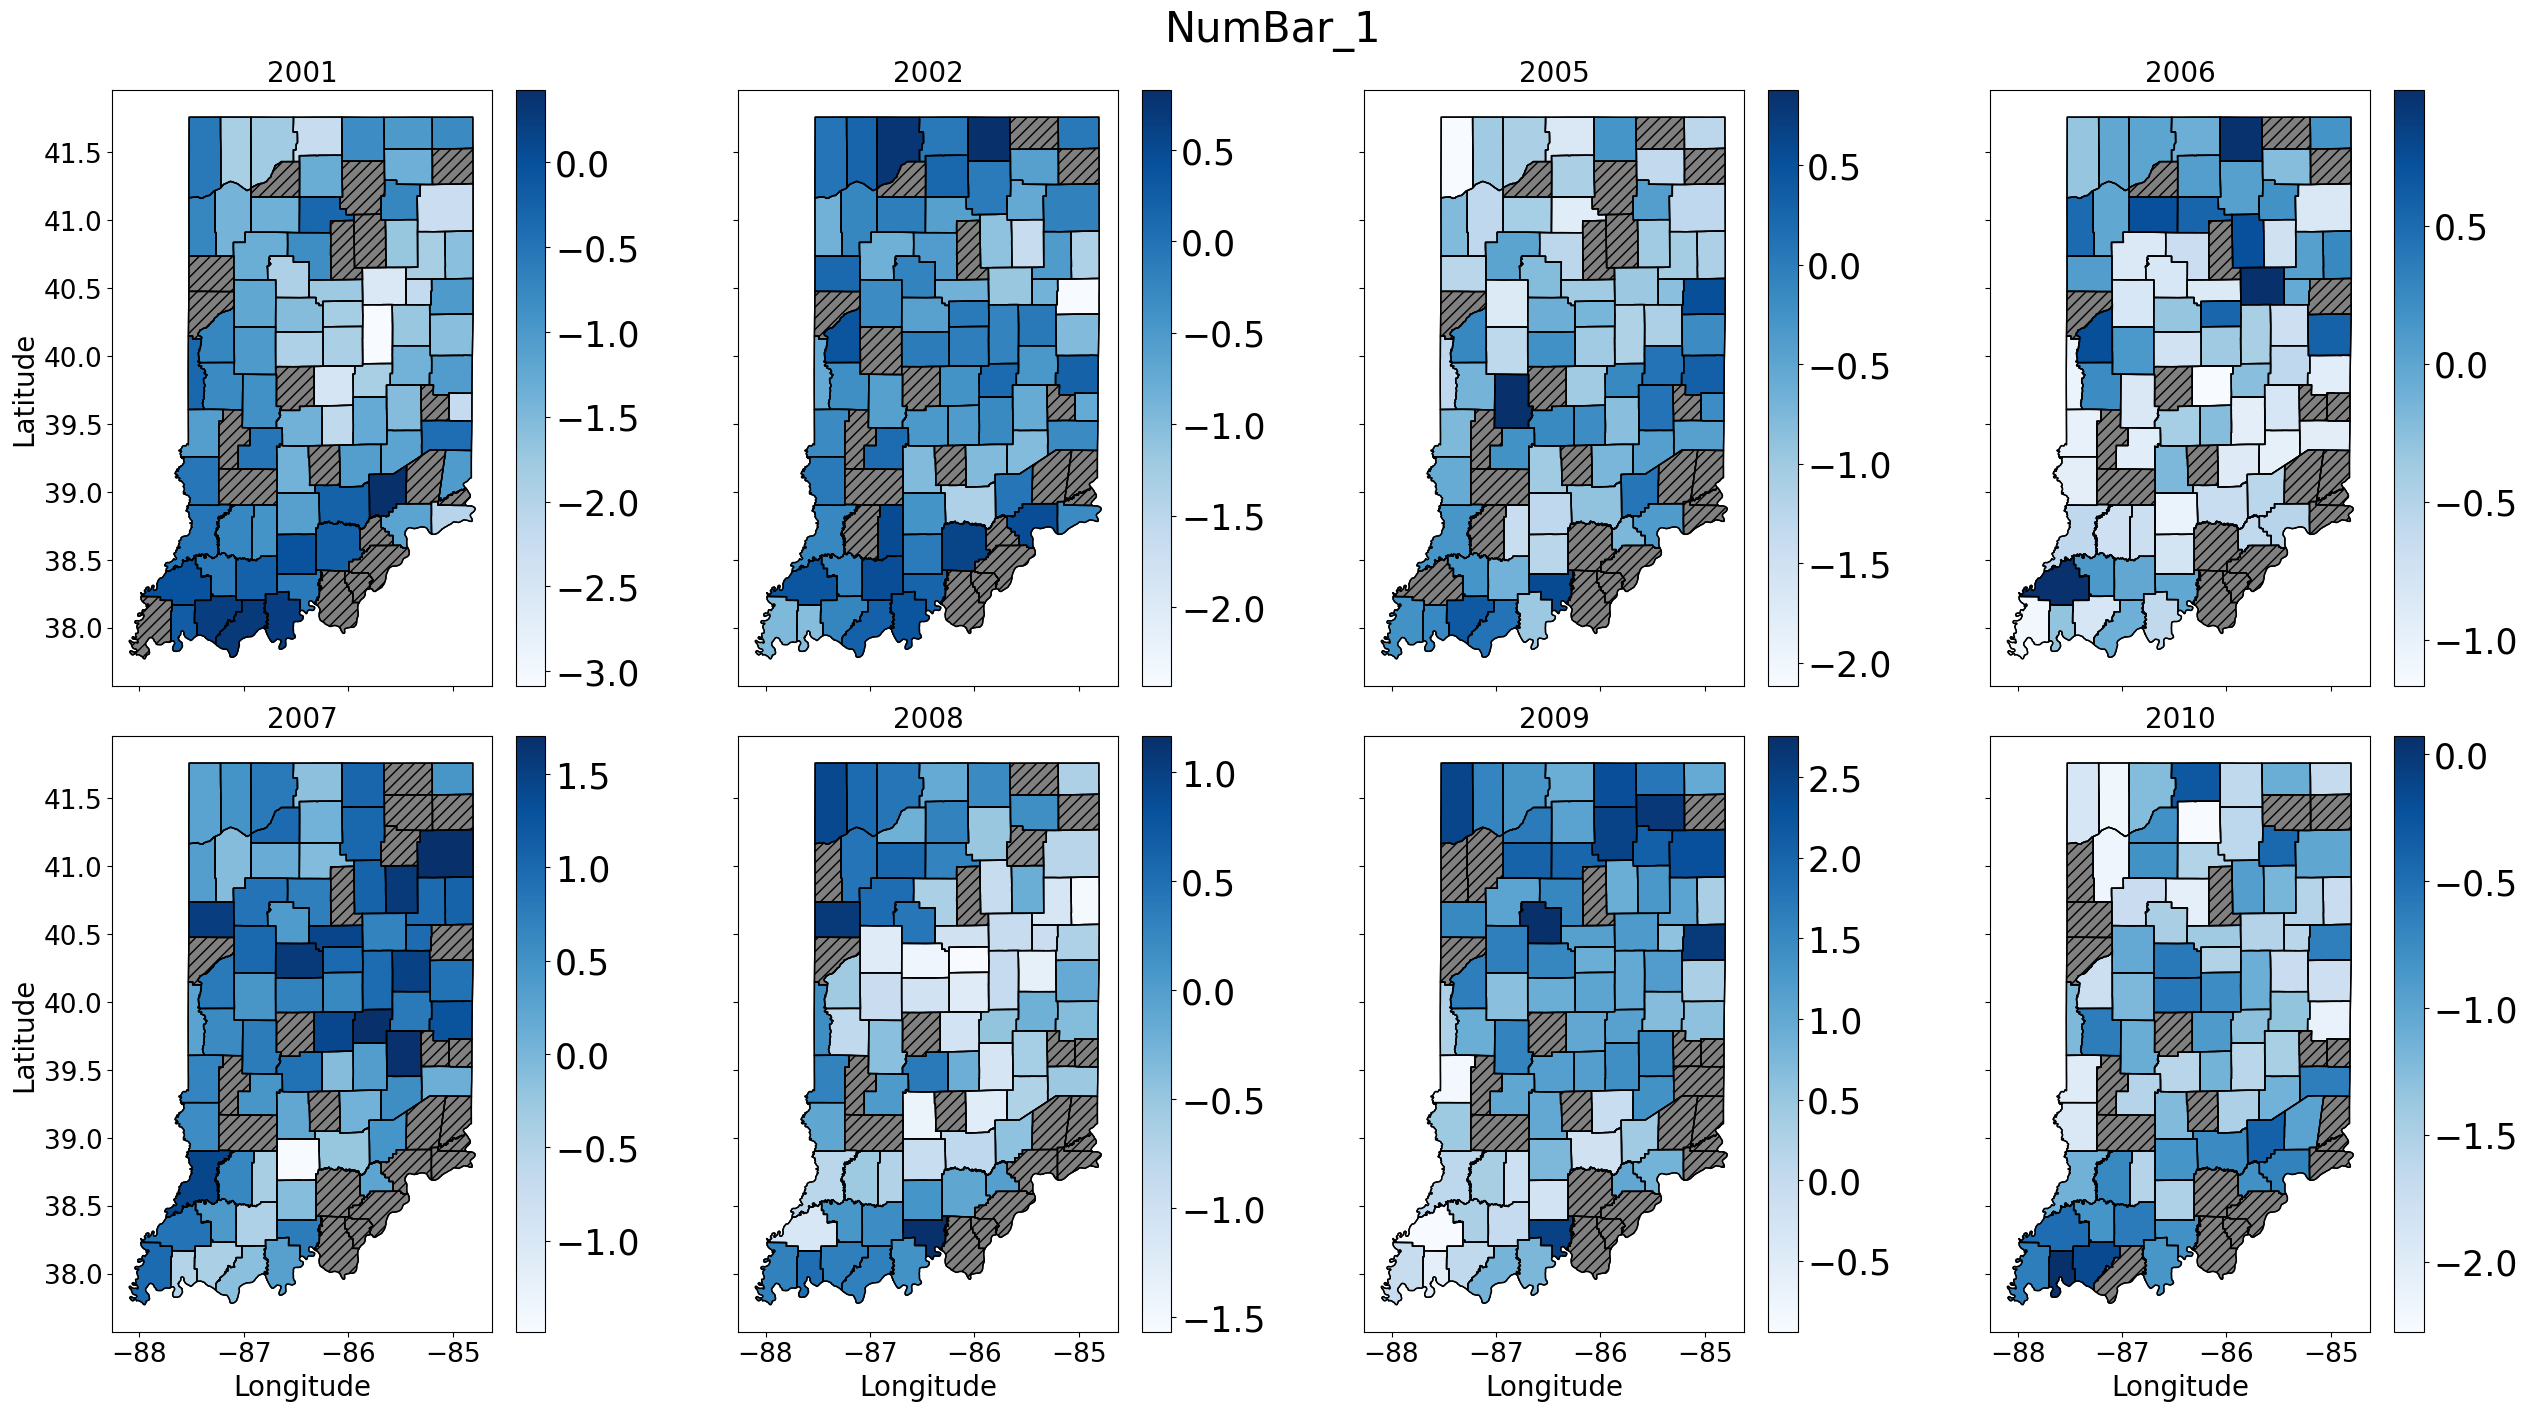

In [ ]:
makemap(df_topo_features, 'Blues', 'NumBar_1')